# Argo Vertical Spectra

This notebook is based on Dhruv's vertical_spectra notebook with glider data

In [165]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import argopy
import scipy.ndimage as filter
import cartopy.crs as ccrs
import cartopy
import xrft
import scipy
import matplotlib

In [198]:
ds_660_grid = xr.open_dataset('ctd_660_vert_4m_binned_29_june_2021.nc')
ds_660_grid

<xarray.Dataset>
Dimensions:       (ctd_pressure: 250, dives: 1007)
Coordinates:
  * ctd_pressure  (ctd_pressure) float64 2.0 6.0 10.0 14.0 ... 990.0 994.0 998.0
  * dives         (dives) float64 1.0 1.5 2.0 2.5 ... 508.0 508.5 509.0 509.5
Data variables:
    sigma0        (ctd_pressure, dives) float64 ...
    SA            (ctd_pressure, dives) float64 ...
    CT            (ctd_pressure, dives) float64 ...
    time          (ctd_pressure, dives) datetime64[ns] ...
    latitude      (ctd_pressure, dives) float64 ...
    longitude     (ctd_pressure, dives) float64 ...
Attributes:
    units:          kg/m^3
    comment:        Calculated using GSW
    standard_name:  Potential Density Anomaly
    platform:       glider
    history:        [2021-07-26 18:06:26] (v2021.3) glidertools.cleaning.outl...
    outlier_lims:   [33.83323076 35.65218568]

In [207]:
def glider_ds_filt(ds_interp,first,last,num,variable='CT'):
    sigmas=np.logspace(first,last,num)
    temp=np.zeros((ds_interp.ctd_pressure.shape[0],ds_interp.dives.shape[0],num))

    for n in range(0,num):
        temp[:,:,n]=filter.gaussian_filter1d(ds_interp[variable],sigma=sigmas[n],mode='nearest')

    ds_filt=xr.DataArray(temp,dims=['ctd_pressure','dives','filt_scale'],
        coords={'ctd_pressure':ds_interp.ctd_pressure,'dives':ds_interp.dives,'filt_scale':sigmas})

    #number=np.arange(0,len(ds_filt.N_PROF))
    #ds_filt['dives_new']=xr.DataArray(number,dims=ds_filt.dives.dims)
    return ds_filt

In [208]:
def glider_var(ds_interp,ds_filt,variable='TEMP'):
    var=np.zeros(len(ds_filt.filt_scale))
    for n,sig in enumerate(ds_filt.filt_scale):
        prof_filt=ds_filt.sel(filt_scale=sig)
        var[n]=(prof_filt-prof_interp).var()
    return var

In [209]:
ds_660_filt=glider_ds_filt(ds_660_grid,0.5,2.5,50)
ds_660_var=glider_var(ds_660_grid,ds_660_filt)

/home.ufs/amf2288/.conda/envs/argo/lib/python3.10/site-packages/xarray/core/nputils.py:155: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/home.ufs/amf2288/.conda/envs/argo/lib/python3.10/site-packages/xarray/core/nputils.py:155: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/home.ufs/amf2288/.conda/envs/argo/lib/python3.10/site-packages/xarray/core/nputils.py:155: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/home.ufs/amf2288/.conda/envs/argo/lib/python3.10/site-packages/xarray/core/nputils.py:155: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


(3.1622776601683795e-05, 3.1622776601683795)

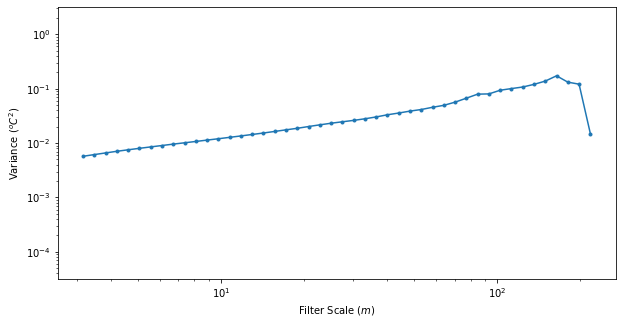

In [210]:
plt.figure(figsize=(10,5))
plt.plot(ds_660_filt.filt_scale,ds_660_var,'.-')
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Filter Scale ($m$)")
plt.ylabel("Variance ($^oC^2$)")
plt.ylim(10**-4.5,10**0.5)

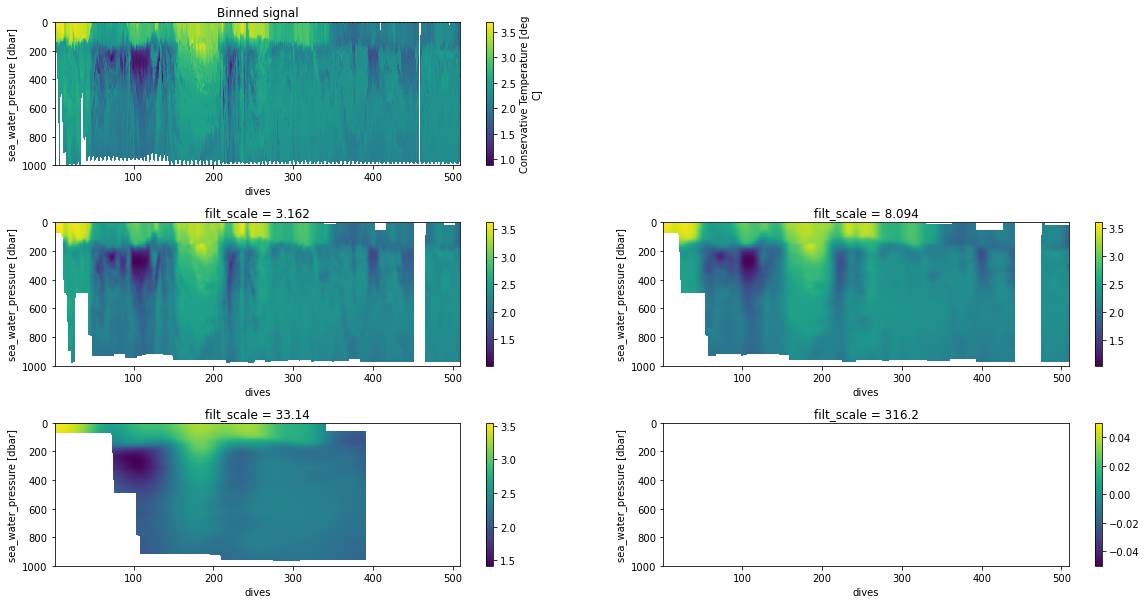

In [211]:
plt.figure(figsize=(20,10))

plt.subplot(3,2,1)
ds_660_grid.CT.plot(x='dives',y='ctd_pressure')
plt.gca().invert_yaxis()
plt.title('Binned signal')

plt.subplot(3,2,3)
ds_660_filt.isel(filt_scale=0).plot()
plt.gca().invert_yaxis()

plt.subplot(3,2,4)
ds_660_filt.isel(filt_scale=10).plot()
plt.gca().invert_yaxis()

plt.subplot(3,2,5)
ds_660_filt.isel(filt_scale=25).plot()
plt.gca().invert_yaxis()

plt.subplot(3,2,6)
ds_660_filt.isel(filt_scale=49).plot()
plt.gca().invert_yaxis()

plt.subplots_adjust(hspace=0.4,wspace=0.2)

In [214]:
def argo_ds_interp(ds,depth_min,depth_max,sample_max):
    median_dp=ds.PRES.where(ds.PRES<depth_max).where(ds.PRES>depth_min).diff('N_LEVELS').median('N_LEVELS')
    ind_rate=median_dp.where(median_dp<sample_max,drop=True).N_PROF
    ds_sel=ds.sel(N_PROF=ind_rate)
    ds_interp=ds_sel.argo.interp_std_levels(np.arange(depth_min,depth_max,2)) #is this where we lose other variables?
    ds_interp=ds_interp.sortby(ds_interp.N_PROF)
    
    number=np.arange(0,len(ds_interp.N_PROF))
    ds_interp.coords['N_PROF_NEW']=xr.DataArray(number,dims=ds_interp.N_PROF.dims)
    return ds_interp

def argo_ds_filt(ds_interp,first,last,num,variable='TEMP'):
    sigmas=np.logspace(first,last,num)
    temp=np.zeros((ds_interp.N_PROF.shape[0],ds_interp.PRES_INTERPOLATED.shape[0],num))

    for n in range(0,num):
        temp[:,:,n]=filter.gaussian_filter1d(ds_interp[variable],sigma=sigmas[n],mode='nearest')

    ds_filt=xr.DataArray(temp,dims=['N_PROF','PRES_INTERPOLATED','FILT_SCALE'],
             coords={'N_PROF':ds_interp.N_PROF,'PRES_INTERPOLATED':ds_interp.PRES_INTERPOLATED,'FILT_SCALE':sigmas})
    
    number=np.arange(0,len(ds_filt.N_PROF))
    ds_filt['N_PROF_NEW']=xr.DataArray(number,dims=ds_filt.N_PROF.dims)
    return ds_filt

def argo_var(ds_interp,ds_filt,variable='TEMP'):
    var=np.zeros(len(ds_filt.FILT_SCALE))
    for n,sig in enumerate(ds_filt.FILT_SCALE):
        prof=ds_filt.sel(FILT_SCALE=sig)
        var[n]=(prof-ds_interp[variable]).var()
    return var

In [240]:
np_ds=xr.open_dataset("202206_lon:(-155,-145)_lat:(30,35).nc")
np_interp=argo_ds_interp(np_ds,200,2000,3)
np_filt=argo_ds_filt(np_interp,0.5,2.5,50)
np_var=argo_var(np_interp,np_filt)

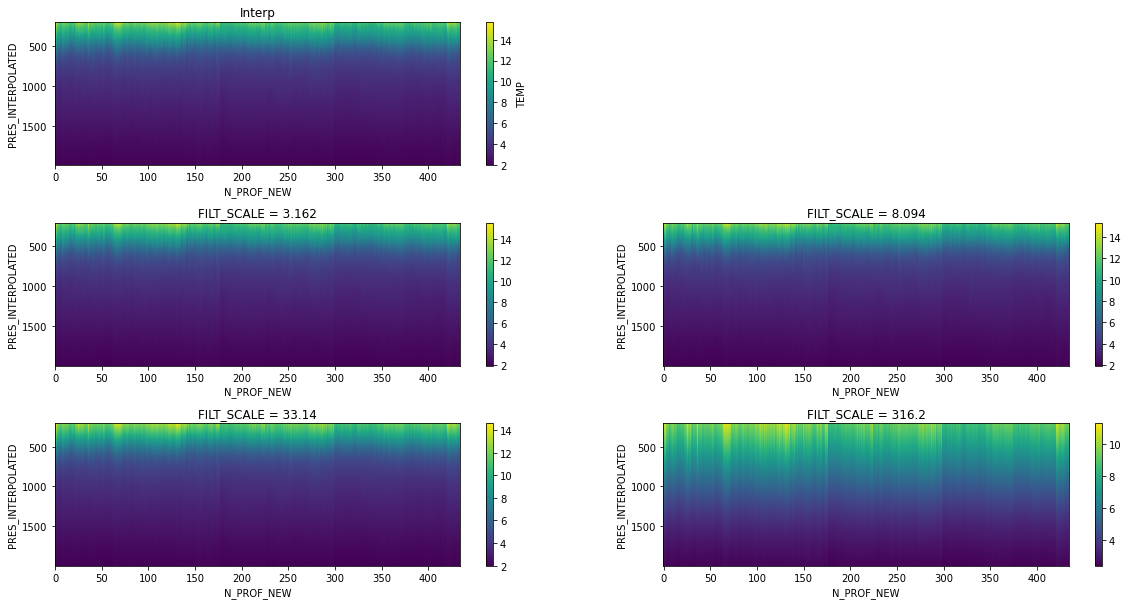

In [241]:
plt.figure(figsize=(20,10))

plt.subplot(3,2,1)
np_interp.TEMP.plot(x='N_PROF_NEW',y='PRES_INTERPOLATED')
plt.gca().invert_yaxis()
plt.title('Interp')

plt.subplot(3,2,3)
np_filt.isel(FILT_SCALE=0).plot(x='N_PROF_NEW',y='PRES_INTERPOLATED')
plt.gca().invert_yaxis()

plt.subplot(3,2,4)
np_filt.isel(FILT_SCALE=10).plot(x='N_PROF_NEW',y='PRES_INTERPOLATED')
plt.gca().invert_yaxis()

plt.subplot(3,2,5)
np_filt.isel(FILT_SCALE=25).plot(x='N_PROF_NEW',y='PRES_INTERPOLATED')
plt.gca().invert_yaxis()

plt.subplot(3,2,6)
np_filt.isel(FILT_SCALE=49).plot(x='N_PROF_NEW',y='PRES_INTERPOLATED')
plt.gca().invert_yaxis()

plt.subplots_adjust(hspace=0.4,wspace=0.2)